# **Jax**

In [1]:
# make sure jax is using the gpu
from jax.lib import xla_bridge
print(f"JAX device: {xla_bridge.get_backend().platform}")

#rest of the imports
import jax
import timeit
import jax.numpy as jnp
from sine_gaussian_jax import SineGaussianJax

JAX device: gpu


In [12]:
sample_rate = 4096.0
duration = 10.0

sg_jax = SineGaussianJax(sample_rate, duration)

quality = jnp.linspace(3, 100, 1000)
frequency = jnp.logspace(1, 3, 1000)
hrss = jnp.logspace(-23, -6, 1000)
phase = jnp.linspace(0, 2 * jnp.pi, 1000)
eccentricity = jnp.linspace(0, 0.99, 1000)

sg_jit = jax.jit(sg_jax)

#benchmark speed
print("Regular Jax")
print(timeit.timeit(lambda: sg_jax(quality, frequency, hrss, phase, eccentricity), number=1000))
print("Jax with JIT")
print(timeit.timeit(lambda: sg_jit(quality, frequency, hrss, phase, eccentricity), number=1000))


Regular Jax


10.97544801999993
Jax with JIT
1.6724556210001538


# **Torch**

In [10]:
# make sure torch is using the gpu
import torch
print(f"Torch GPU Available: {torch.cuda.is_available()}, {torch.cuda.get_device_name(0)}")

#rest of the imports
import timeit
import numpy as np
from sine_gaussian import SineGaussian

Torch GPU Available: True, GRID A100X-20C


In [27]:
sample_rate = 4096.0
duration = 10.0

sg_torch = SineGaussian(sample_rate, duration)

quality = torch.linspace(3, 100, 1000).cuda()
frequency = torch.logspace(1, 3, 1000).cuda()
hrss = torch.logspace(-23, -6, 1000).cuda()
phase = torch.linspace(0, 2 * np.pi, 1000).cuda()
eccentricity = torch.linspace(0, 0.99, 1000).cuda()

sg_torch = sg_torch.cuda()

#benchmark speed
print(timeit.timeit(lambda: sg_torch(quality, frequency, hrss, phase, eccentricity), number=1000))

7.556493054999919


# **Comparision**

In [1]:
import matplotlib.pyplot as plt

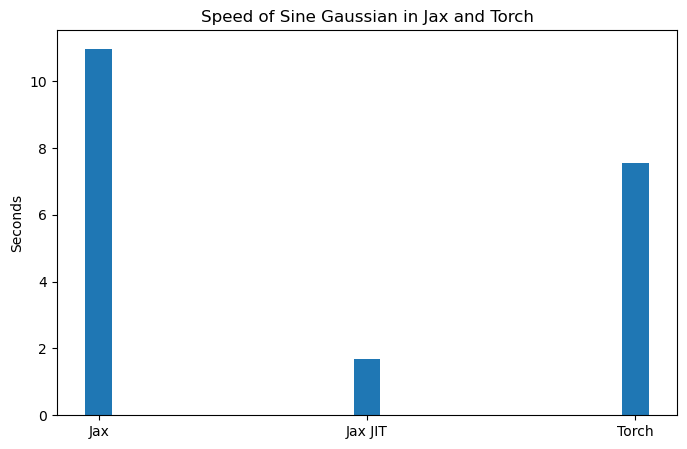

In [8]:
results = [10.97544801999993, 1.6724556210001538, 7.556493054999919]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.bar(["Jax", "Jax JIT", "Torch"], results, width=0.1)
ax.set_ylabel("Seconds")
ax.set_title("Speed of Sine Gaussian in Jax and Torch")
plt.show()